# Guiding questions

How does graduate student gender diversity at Columbia compare to its peer institutions?

In [2]:
from collections import defaultdict
import math
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [24]:
TOTALS = pickle.load(open('../../../data/SE-Detailed_Sex.p', 'rb'))
S_TOTALS = pickle.load(open('../../../data/S_Sex_Graduates.p', 'rb'))

years = sorted(TOTALS.keys())
institutions = sorted(TOTALS[ max(years) ].keys())
fields = {
    'Science': set(),
    'Engineering': set()
}
for year in years:
    inst_stats = TOTALS[year]['Columbia University in the City of New York']
    for seh in inst_stats.keys():
        for field in inst_stats[seh].keys():
            fields[seh].add(field)
fields['Science'] = sorted(fields['Science'])
fields['Engineering'] = sorted(fields['Engineering'])

print(f'Data set describes years {min(years)} - {max(years)} for {len(institutions)} institutions and {len(fields["Science"]) + len(fields["Engineering"])} fields.')                                                                                                                   
      

Data set describes years 1994 - 2016 for 11 institutions and 39 fields.


In [137]:
# Convenient function for making subplots for every institution
def subplots(num=len(institutions), cols=2, figsize=8):
    rows = math.ceil(num / cols)
    return plt.subplots(rows, cols, figsize=(figsize * cols, figsize * rows))

# Returns female proportions for an institution in a field
def get_proportions(seh, field, inst='Columbia University in the City of New York'):
    proportions = []
    for year in years:
        field_stats = TOTALS[year][inst][seh].get(field, None)
        if field_stats is None:
            proportions.append(None)
        else:
            proportions.append(field_stats.get('Female', 0) / field_stats['Total for selected values'])
    return proportions

# Plots female proportions for every institution for a field, highlighting one, in a line graph
def plot_inst(ax, seh, field, highlight='Columbia University in the City of New York'):
    for inst in institutions:
        if inst != highlight:
            ax.plot(years, get_proportions(seh, field, inst), label=inst)
    ax.plot(years, get_proportions(seh, field, highlight), label=highlight, linewidth=3, color='black')
    
    ax.set_ylabel('Percent female')
    ax.legend()
    ax.set_ylim(top=1, bottom=0)
    ax.set_title(f'{field}: Comparing Columbia\'s peers')
    
    # Format y tick labels to be percentages
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

# Returns female and male headcounts for a field in an institution
def get_counts(seh, field, inst='Columbia University in the City of New York', default=None):
    females = []
    males = []
    for year in years:
        stats = TOTALS[year][inst][seh].get(field, None)
        if stats is None:
            females.append(default)
            males.append(default)
            continue
        females.append(stats.get('Female', 0))
        males.append(stats.get('Male', 0))
    return females, males

# Plots a female and male headcounts line graph for a field in an institution
def plot_counts(ax, seh, field, inst='Columbia University in the City of New York'):
    females, males = get_counts(seh, field, inst)
    ax.plot(years, females, label='Female')
    ax.plot(years, males, label='Male')
    ax.legend()
    ax.set_ylim(bottom=0)
    ax.set_title(f'{field}: Columbia\'s headcounts by sex')
    ax.set_ylabel('Number of people')

def plot_connected(ax, seh, field, inst='Columbia University in the City of New York'):
    f, m = get_counts(seh, field, inst, default=0)
    ax.plot(f, m, color='lightgray')
    ax.scatter(f, m, c=[i for i in range(len(m))], cmap='viridis')

    for i in [0, -1]:
        ax.annotate(years[i], (f[i], m[i]))
    
    _, ymax = ax.get_ylim()
    _, xmax = ax.get_xlim()
    top = max(ymax, xmax)
    
    ax.set_ylim(bottom=0, top=top)
    ax.set_xlim(left=0, right=top)
    
    ax.plot([0, top], [0, top], color='gray', linestyle='--')

    ax.set_xlabel('Number of women')
    ax.set_ylabel('Number of men')

## Absolute change since 2006 for different fields

In [94]:
field_ary = fields['Science']

target_years = years[1995 - years[0]:]
df = {}
df['years'] = target_years
for field in field_ary:
    females, males = get_counts('Science', field, default=0)
    changes = []
    for year in target_years:
        i = year - years[0]
        changes.append((males[i] - males[i-1]) - (females[i] - females[i-1]))
    df[field] = changes

changes = []
females, males = [], []
for year in years:
    stats = S_TOTALS[year]['Columbia University in the City of New York']
    females.append(stats['Female'])
    males.append(stats['Male'])

for year in target_years:
    i = year - years[0]
    changes.append((males[i] - males[i-1]) - (females[i] - females[i-1]))
df['Sciences'] = changes
pd.DataFrame(df).to_csv('changes.csv')

In [98]:
def plot_topic(seh, selected_fields):
    fig, axArr = subplots(len(selected_fields)*3, cols=3)
    for i, field in enumerate(selected_fields):
        plot_inst(axArr[i, 0], seh, field)
        plot_counts(axArr[i, 1], seh, field)
        plot_connected(axArr[i, 2], seh, field)

In [128]:
def get_overalls(completes, topic, inst):
    overallF = [0 for _ in range(len(years))]
    overallM = [0 for _ in range(len(years))]
    counts = {field: get_counts(topic, field, inst, default=0) for field in completes}

    for field in completes:
        f, m = counts[field]
        for i in range(len(years)):
            overallF[i] += f[i]
            overallM[i] += m[i]
    return [0 if m+f == 0 else f/(m+f) for f, m in zip(overallF, overallM)]

def plot_topic_clean(ax, topic):
    completes = []
    for field in fields[topic]:
        f, m = get_counts(topic, field)
        if None not in f and None not in m:
            completes.append(field)

    for inst in institutions:        
        ax.plot(years, get_overalls(completes, topic, inst), label=inst)
    ax.set_ylim(bottom=0, top=1)
    ax.legend()

In [134]:
topic = 'Science'
completes = []
for field in fields[topic]:
    complete = True
    for inst in institutions:
        f, m = get_counts(topic, field, inst)
        if None in f or None in m:
            complete = False
            break
    if complete:
        completes.append(field)

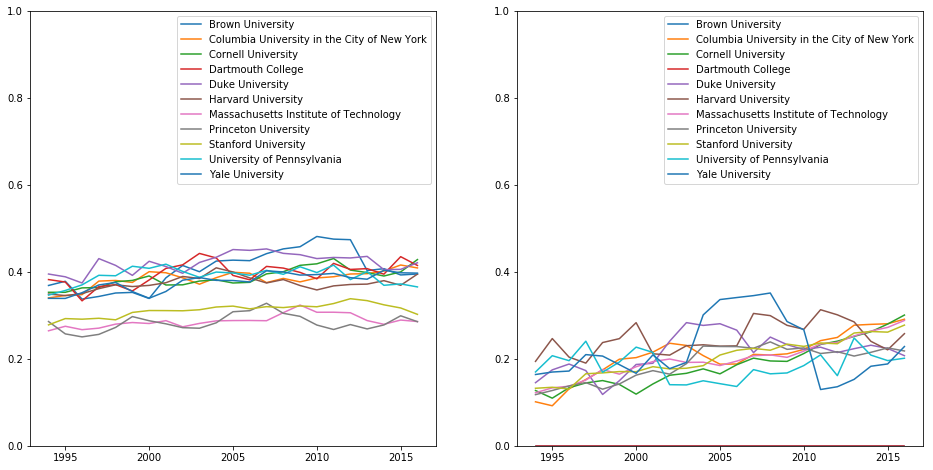

In [127]:
_, ax = plt.subplots(1, 2, figsize=(16, 8))
plot_topic_clean(ax[0], 'Science')
plot_topic_clean(ax[1], 'Engineering')

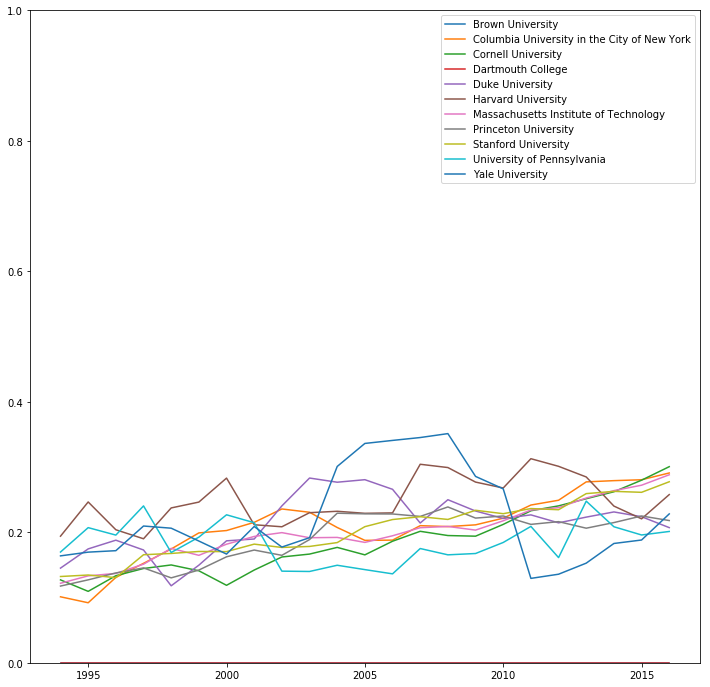

In [110]:
completes = []
for field in fields['Engineering']:
    f, m = get_counts('Engineering', field)
    if None not in f and None not in m:
        completes.append(field)

plt.figure(figsize=(12, 12))
for inst in institutions:
    overallF = [0 for _ in range(len(years))]
    overallM = [0 for _ in range(len(years))]
    counts = {field: get_counts('Engineering', field, inst, default=0) for field in completes}

    for field in completes:
        f, m = counts[field]
        for i in range(len(years)):
            overallF[i] += f[i]
            overallM[i] += m[i]
    plt.plot(years, [0 if m+f == 0 else f/(m+f) for f, m in zip(overallF, overallM)], label=inst)
plt.ylim(bottom=0, top=1)
plt.legend()

(0, 1)

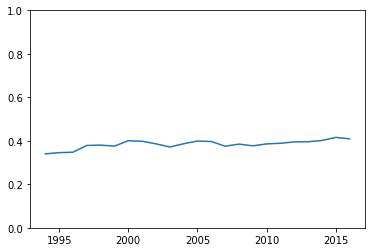

In [104]:
plt.ylim(bottom=0, top=1)

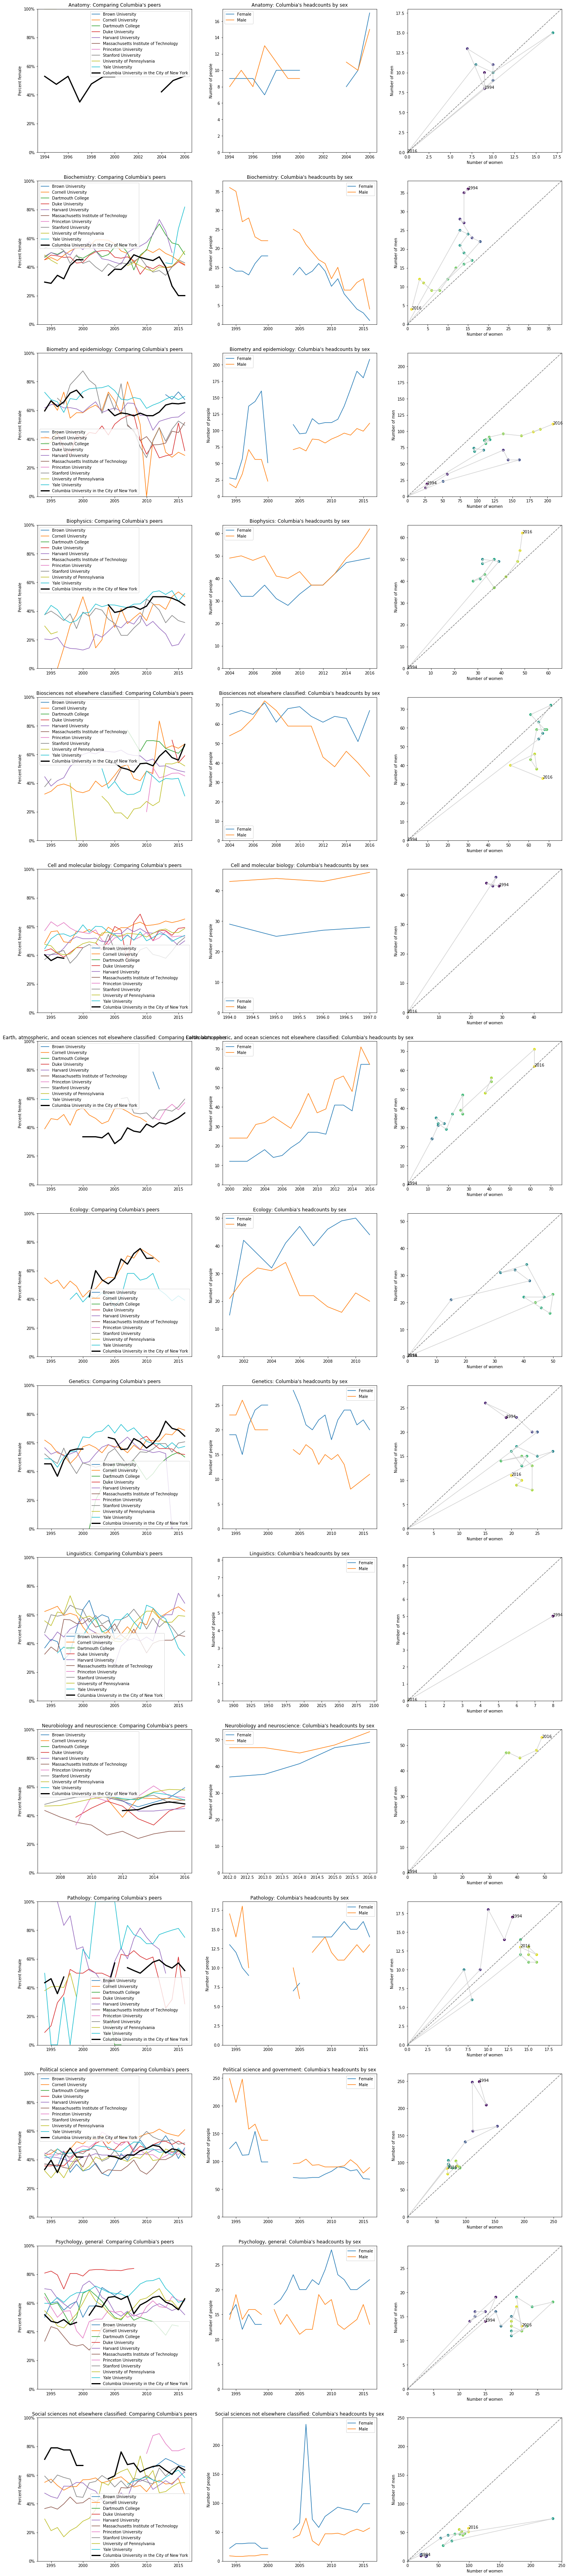

In [100]:
plot_topic('Science', [f for f in fields['Science'] if f not in completes])

(0, 1)

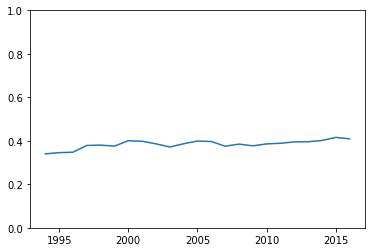

In [74]:
plt.plot(years, [f / (m+f) for f, m in zip(overallF, overallM)])
plt.ylim(bottom=0,top=1)

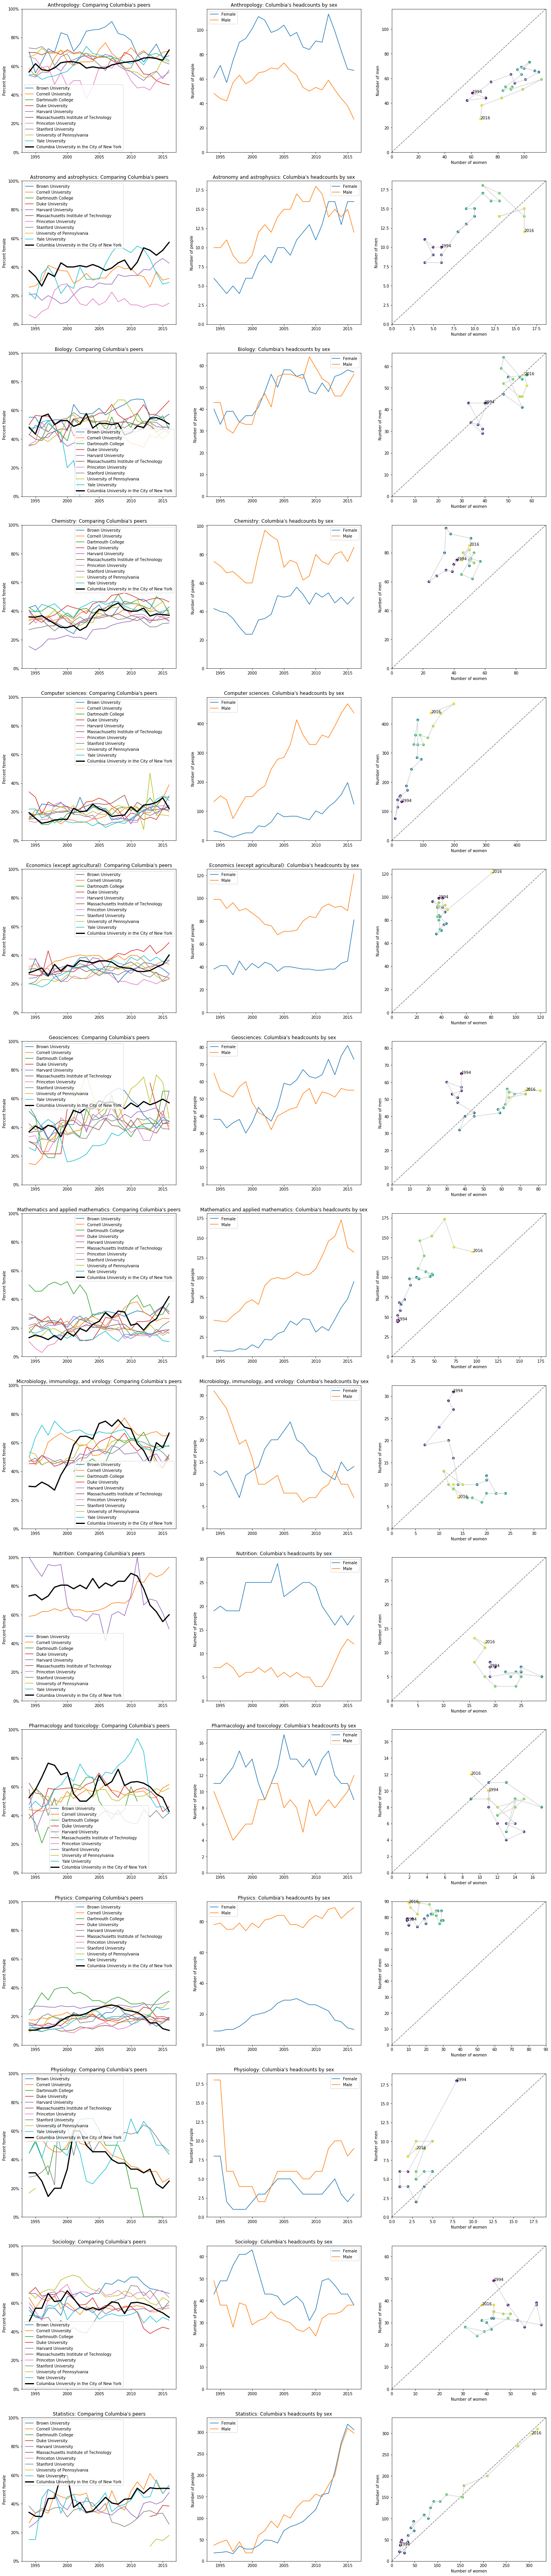

In [53]:
plot_topic('Science')

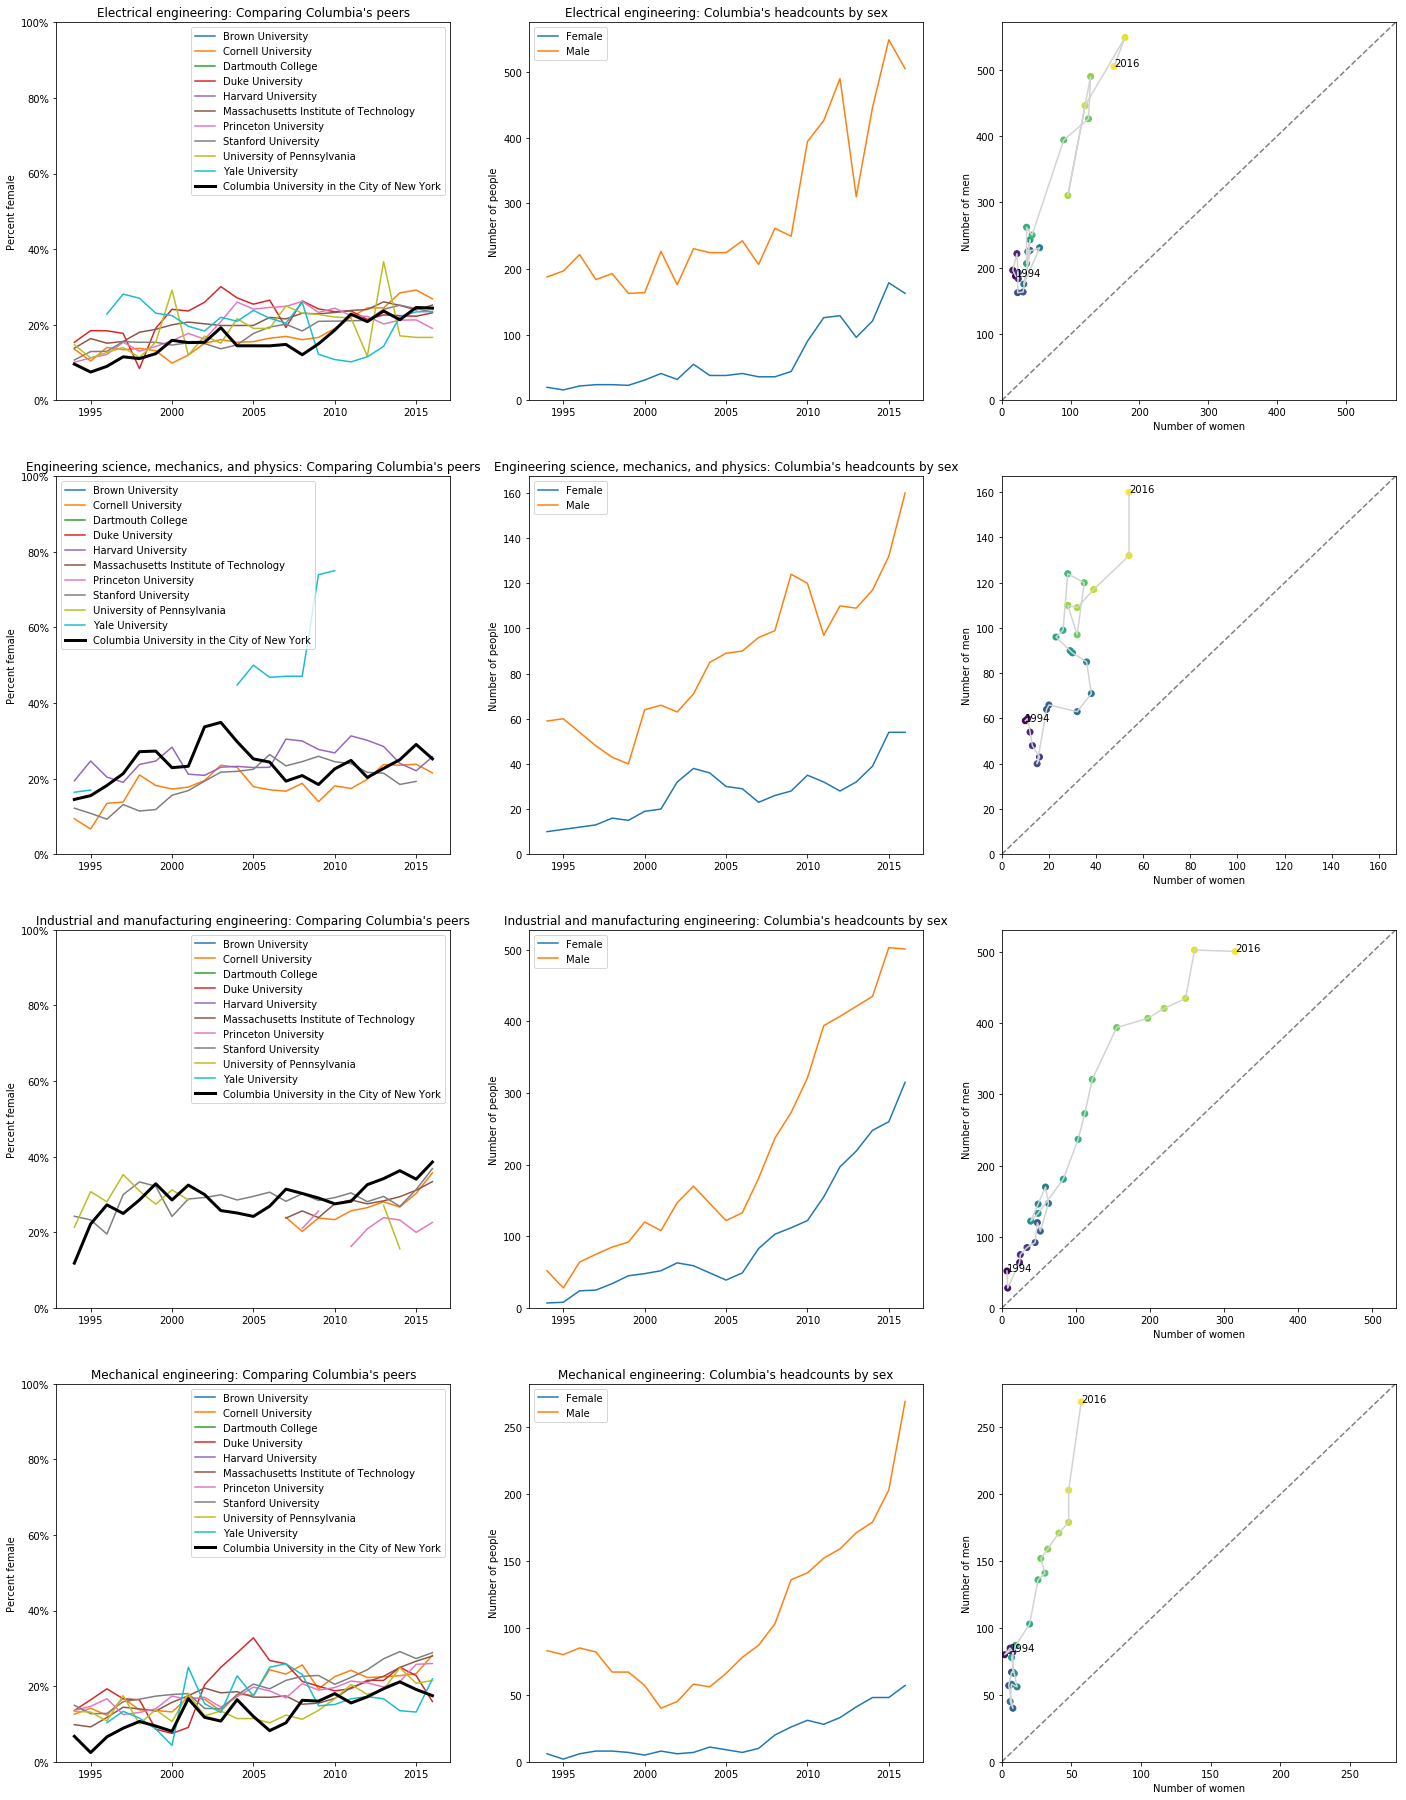

In [54]:
plot_topic('Engineering')